In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import random
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

In [2]:
# Set the random seed for reproducibility
seed = 24#23
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
def random_walk(samples, steps):
    positions = np.zeros(shape=(samples, 2))

    for step in range(steps):
        step = np.random.random(size=(samples, 2)) - 0.5
        norms = np.linalg.norm(step, axis=1)
        normalized_step = step/norms[:, np.newaxis]
        positions += normalized_step

    return positions
    
positions = random_walk(200000, 5).T

In [4]:
np.size(positions, axis=1)

200000

In [5]:
def calculate_probabilities(samples, batch_size, bins, steps):
    x_bins = np.linspace(-steps, steps, bins + 1)
    y_bins = np.linspace(-steps, steps, bins + 1)
    prob_map = []

    for i in range(int(np.size(samples, axis=1)/batch_size)):
        data = samples[:,i*batch_size:(i+1)*batch_size]
        map, _ , _ = np.histogram2d(data[0], data[1], bins=(x_bins, y_bins))
        prob_map.append(map)

    return np.array(prob_map)/batch_size
        
probs_map = calculate_probabilities(positions, 20000, 8, 5)

In [6]:
probs_map[0]

array([[0.000e+00, 2.000e-04, 9.000e-04, 2.250e-03, 2.650e-03, 9.000e-04,
        1.000e-04, 0.000e+00],
       [2.000e-04, 1.950e-03, 7.850e-03, 1.525e-02, 1.540e-02, 8.050e-03,
        1.800e-03, 5.000e-05],
       [1.250e-03, 8.100e-03, 2.740e-02, 4.365e-02, 4.605e-02, 2.730e-02,
        9.350e-03, 9.500e-04],
       [2.750e-03, 1.515e-02, 4.230e-02, 7.650e-02, 7.670e-02, 4.695e-02,
        1.365e-02, 2.900e-03],
       [2.050e-03, 1.425e-02, 4.400e-02, 7.910e-02, 7.970e-02, 4.410e-02,
        1.575e-02, 2.200e-03],
       [1.100e-03, 8.000e-03, 2.530e-02, 4.555e-02, 4.535e-02, 2.575e-02,
        8.050e-03, 1.100e-03],
       [1.500e-04, 2.650e-03, 8.050e-03, 1.605e-02, 1.520e-02, 9.000e-03,
        2.150e-03, 1.000e-04],
       [0.000e+00, 1.000e-04, 9.000e-04, 2.450e-03, 2.400e-03, 7.500e-04,
        2.000e-04, 0.000e+00]])

In [7]:
class WalkDataset(Dataset):
    def __init__(self, probs):
        self.data = torch.tensor(probs, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [8]:
# Create the data loader instance
dataset = WalkDataset(probs_map.reshape(10, 64))
dataloader = DataLoader(dataset, batch_size=1)

In [9]:
n_qubits = 7
a_qubits = 1
q_depth = 6 

In [10]:
# Discriminator implementation

class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(64, 100),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(100, 20),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        
        return self.model(x)


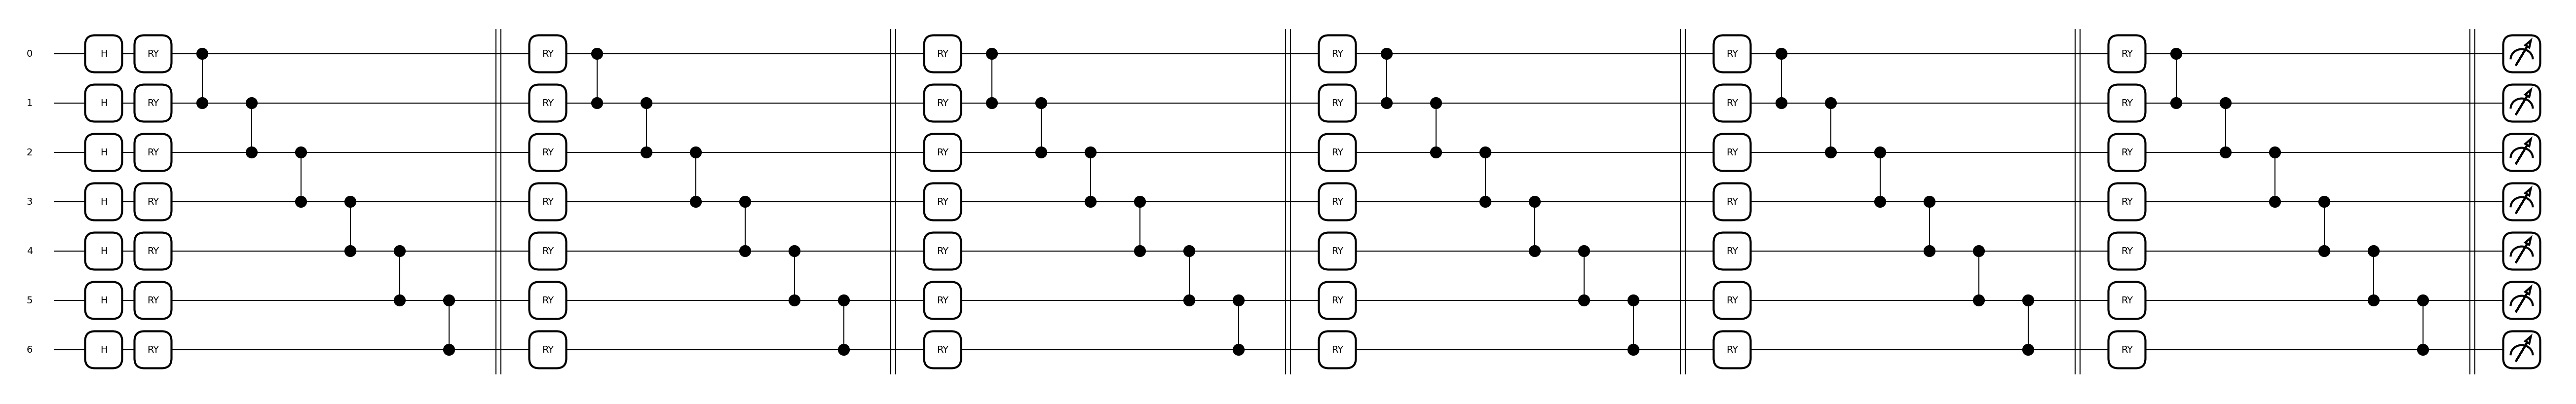

In [11]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="backprop")
def quantum_circuit(weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        #qml.CZ(wires=[5, 0])

        qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    return qml.probs(wires=list(range(n_qubits)))

noise = torch.rand(1, n_qubits, device=device) 
weights = torch.rand(1, n_qubits*q_depth) 

qml.draw_mpl(quantum_circuit)(weights=weights)
plt.show()

In [12]:
def partial_measure(qc, weights):
    # Non-linear Transform
    probs = qc(weights)
    probsgiven0 = probs[: (2 ** (n_qubits - a_qubits))]
    probsgiven0 /= torch.sum(probsgiven0)

    # Post-Processing
    #probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven0

In [13]:
class QuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(torch.rand(q_depth * n_qubits), requires_grad=True)
            ]
        )

    def forward(self):

        qc_out = partial_measure(quantum_circuit, self.q_params[0]).float().unsqueeze(0)
        
        return qc_out
        

In [14]:
discriminator = Discriminator().to(device)
generator = QuantumGenerator().to(device)

In [15]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 1000  # Number of training iterations

In [16]:
# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []
frenchet_d = []

In [17]:
from scipy.linalg import sqrtm

def calculate_frechet_distance(real_data, generated_data):
    mu_r = np.mean(real_data, axis=0)
    mu_g = np.mean(generated_data, axis=0)
    C_r = np.cov(real_data, rowvar=False)
    C_g = np.cov(generated_data, rowvar=False)

    mean_diff = mu_r - mu_g
    cov_mean = sqrtm(C_r.dot(C_g))

    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    distance = mean_diff.dot(mean_diff) + np.trace(C_r + C_g - 2*cov_mean)
    return distance

In [18]:
while True:
    for i, data in enumerate(dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, data.size(0))
        real_data = data.to(device)
        fake_data = generator()

        # Calculate Frenchet Distance
        fd = calculate_frechet_distance(real_data.numpy().reshape(8, 8),fake_data.detach().numpy().reshape(8, 8))

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 10 == 0:
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}, Frenchet Distance: {fd:0.6f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())
        frenchet_d.append(fd)

    counter += 1
    if counter == num_iter:
        break

Iteration: 0, Discriminator Loss: 1.385, Generator Loss: 0.718, Frenchet Distance: 0.004013
Iteration: 10, Discriminator Loss: 1.384, Generator Loss: 0.707, Frenchet Distance: 0.004018
Iteration: 20, Discriminator Loss: 1.384, Generator Loss: 0.701, Frenchet Distance: 0.005689
Iteration: 30, Discriminator Loss: 1.383, Generator Loss: 0.698, Frenchet Distance: 0.006632
Iteration: 40, Discriminator Loss: 1.382, Generator Loss: 0.697, Frenchet Distance: 0.005953
Iteration: 50, Discriminator Loss: 1.381, Generator Loss: 0.696, Frenchet Distance: 0.005216
Iteration: 60, Discriminator Loss: 1.380, Generator Loss: 0.697, Frenchet Distance: 0.003766
Iteration: 70, Discriminator Loss: 1.380, Generator Loss: 0.696, Frenchet Distance: 0.002261
Iteration: 80, Discriminator Loss: 1.382, Generator Loss: 0.694, Frenchet Distance: 0.001922
Iteration: 90, Discriminator Loss: 1.386, Generator Loss: 0.692, Frenchet Distance: 0.002566
Iteration: 100, Discriminator Loss: 1.388, Generator Loss: 0.691, Frenc

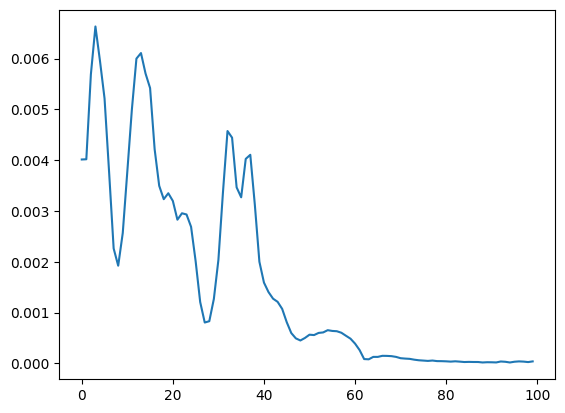

In [42]:
plt.plot(frenchet_d)

# Test

In [20]:
t = generator().detach().numpy()
t = t.reshape(8, 8)
t

array([[3.31498304e-04, 4.18331329e-05, 1.15458237e-03, 5.45091752e-04,
        4.66877216e-04, 1.03040808e-03, 4.87309153e-05, 3.19829443e-04],
       [4.38218240e-06, 2.40510167e-03, 1.11128567e-02, 1.63568277e-02,
        1.69472899e-02, 1.12745855e-02, 2.50622514e-03, 5.20818594e-06],
       [3.14972393e-04, 9.05251689e-03, 2.47297101e-02, 4.70632911e-02,
        4.62544262e-02, 2.37898584e-02, 8.93942174e-03, 3.13904486e-04],
       [1.41639938e-03, 1.76977459e-02, 4.08521555e-02, 7.78901279e-02,
        8.21912363e-02, 4.21954952e-02, 1.87346581e-02, 1.48609059e-03],
       [1.67427148e-04, 1.28931273e-02, 4.97487523e-02, 7.90911391e-02,
        7.84972012e-02, 4.82264385e-02, 1.29062571e-02, 1.78259274e-04],
       [4.12205787e-04, 8.41007940e-03, 2.67952476e-02, 4.25007977e-02,
        4.52996492e-02, 2.78943442e-02, 9.00695659e-03, 4.41040465e-04],
       [3.95907031e-04, 3.55630671e-03, 6.48503238e-03, 1.35822697e-02,
        1.37595199e-02, 6.46687392e-03, 3.59115214e-03, 3.

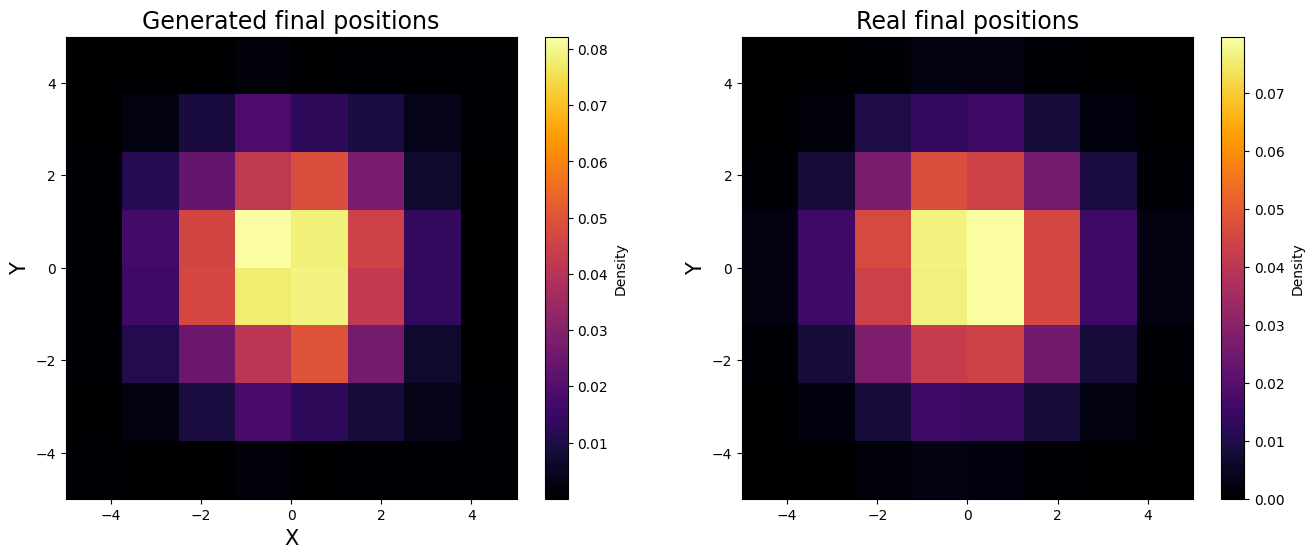

In [21]:
# Crear la figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Primer subplot: Mapa de densidad de posiciones originales
im1 = axs[0].imshow(t.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
axs[0].set_title('Generated final positions', fontsize=17)
axs[0].set_xlabel('X', fontsize=15)
axs[0].set_ylabel('Y', fontsize=15)
fig.colorbar(im1, ax=axs[0], label='Density')

# Segundo subplot: Mapa de densidad de posiciones normalizadas
im2 = axs[1].imshow(probs_map[0].T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
axs[1].set_title('Real final positions', fontsize=17)
axs[1].set_ylabel('X', fontsize=15)
axs[1].set_ylabel('Y', fontsize=15)
fig.colorbar(im2, ax=axs[1], label='Density')

plt.show()

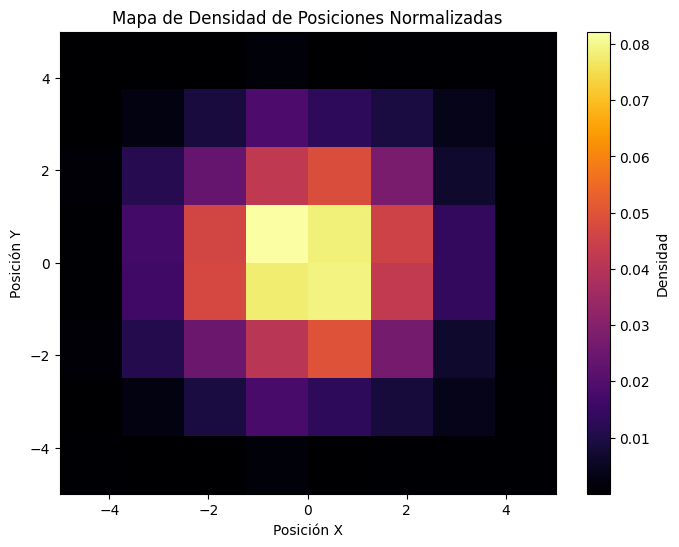

In [22]:

# Visualizar la densidad
plt.figure(figsize=(8, 6))
plt.imshow(t.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Densidad')
plt.title('Mapa de Densidad de Posiciones Normalizadas')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
#plt.grid(True)
plt.show()


# Simulations

In [23]:
# Trained params
for param in generator.parameters():
    trained_params = param

trained_params

Parameter containing:
tensor([ 1.1239,  0.0408,  0.1494,  0.5750,  1.2022,  1.0196,  0.6971,  0.8773,
         0.7414,  0.6274,  1.1037,  0.3052,  0.2357,  0.5552,  0.7187,  0.1856,
         1.3258,  0.3826,  1.3180,  1.3943,  0.9230,  0.4064,  1.5550,  1.1748,
         0.3400,  0.2904,  0.6281,  0.9020,  0.3515,  0.6060,  1.0498,  1.1654,
         0.4006,  0.6128,  0.7021,  0.5128,  1.5544,  1.2049, -0.1491, -0.0819,
         0.5507,  0.7047], requires_grad=True)

In [24]:
dev = qml.device("default.qubit", wires=n_qubits, shots=10000)

@qml.qnode(dev)
def random_walk_simulator(weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        #qml.CZ(wires=[5, 0])

        qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    return qml.probs(wires=list(range(n_qubits)))



In [25]:
real_random_walks = random_walk(40000, 5).T
real_random_walks = calculate_probabilities(real_random_walks, 10000, 8, 5)
real_random_walks.shape

(4, 8, 8)

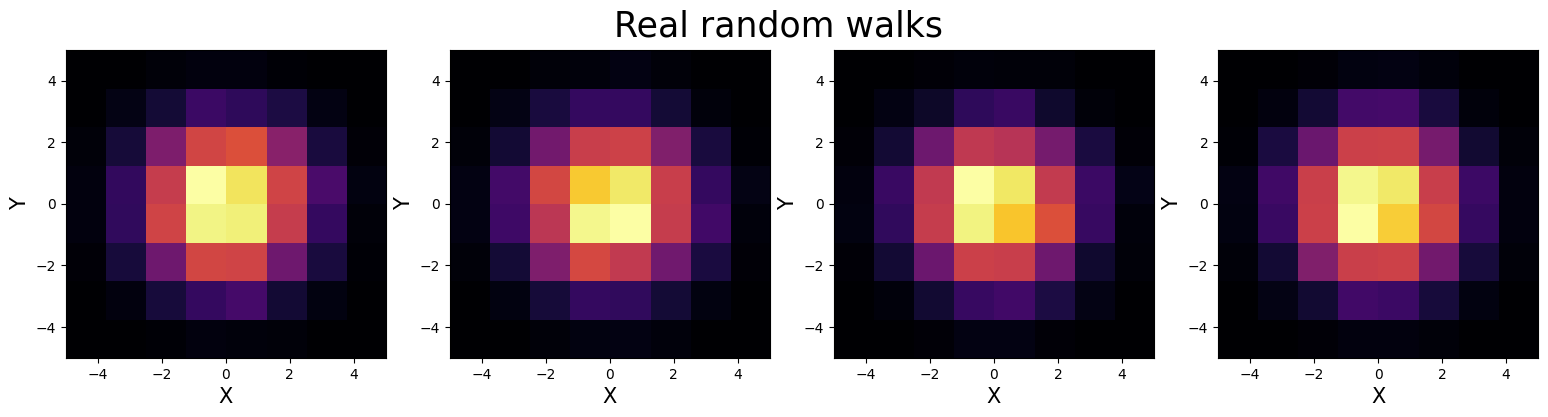

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(19, 4))
real_random_walks = random_walk(40000, 5).T
real_random_walks = calculate_probabilities(real_random_walks, 10000, 8, 5)

for i in range(4):

    axs[i].imshow(real_random_walks[i].T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
    axs[i].set_xlabel('X', fontsize=15)
    axs[i].set_ylabel('Y', fontsize=15)

plt.suptitle("Real random walks", fontsize=25)
plt.show()

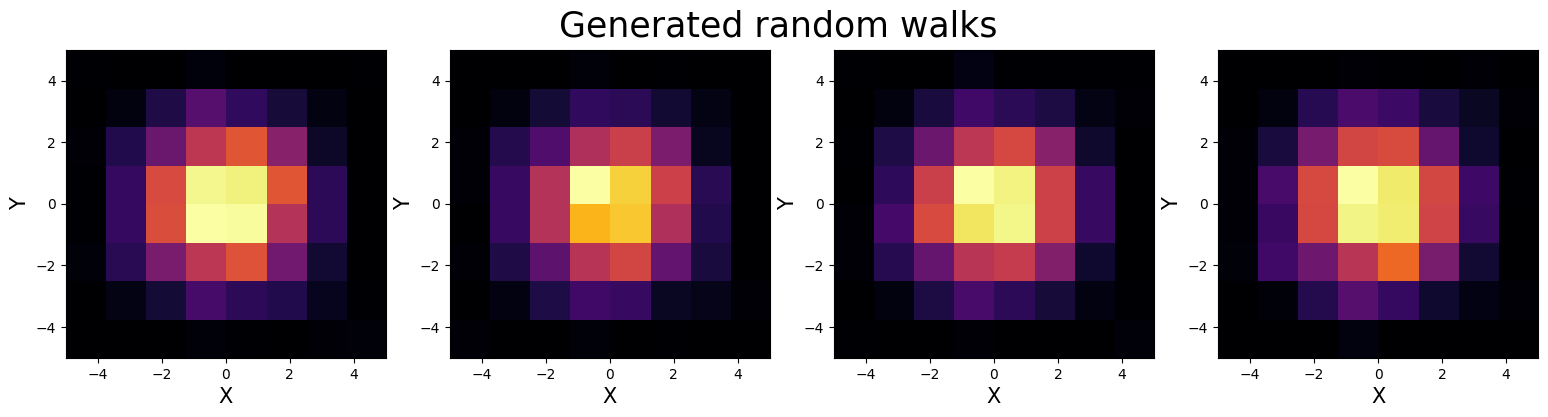

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(19, 4))

for i in range(4):
    gen_random_walks = partial_measure(random_walk_simulator, trained_params).detach().numpy().reshape(8, 8)
    #gen_random_walks = partial_measure(gen_random_walks)

    axs[i].imshow(gen_random_walks.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
    axs[i].set_xlabel('X', fontsize=15)
    axs[i].set_ylabel('Y', fontsize=15)

plt.suptitle("Generated random walks", fontsize=25)
plt.show()



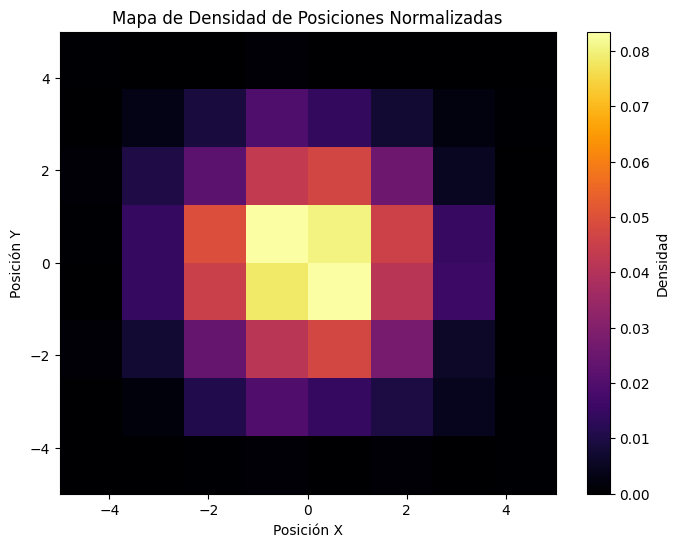

In [39]:
random_walks = partial_measure(random_walk_simulator, trained_params).detach().numpy().reshape(8, 8)

# Visualizar la densidad
plt.figure(figsize=(8, 6))
plt.imshow(random_walks.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Densidad')
plt.title('Mapa de Densidad de Posiciones Normalizadas')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
#plt.grid(True)
plt.show()
